In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Read data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')



In [2]:
import polars as pl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def create_paired_heatmaps(df, metric):
    """
    Create paired heatmaps (original and normalized) for the given metric
    """
    # Create pivot table
    pivot = (df
        .pivot(
            values=metric,
            index='sigma',
            columns='fee_rate',
            aggregate_function='mean'
        )
        .sort('sigma')
    )
    
    # Convert to numpy arrays for heatmap
    sigma_values = pivot.get_column('sigma').to_numpy()
    fee_rate_values = [float(col) for col in pivot.columns[1:]]
    z_values = pivot.select(pivot.columns[1:]).to_numpy()
    
    # Create normalized values (normalize within each sigma)
    z_normalized = np.zeros_like(z_values)
    for i in range(z_values.shape[0]):
        row = z_values[i, :]
        z_normalized[i, :] = (row - np.min(row)) / (np.max(row) - np.min(row))
    
    # Create subplot figure
    fig = make_subplots(
        rows=1, 
        cols=2,
        subplot_titles=["Original Values", "Normalized within Sigma"],
        horizontal_spacing=0.15
    )
    
    # Add original heatmap
    fig.add_trace(
        go.Heatmap(
            z=z_values,
            x=fee_rate_values,
            y=sigma_values,
            colorscale='RdBu',
            colorbar=dict(
                title=metric,
                x=0.45
            )
        ),
        row=1, 
        col=1
    )
    
    # Add normalized heatmap
    fig.add_trace(
        go.Heatmap(
            z=z_normalized,
            x=fee_rate_values,
            y=sigma_values,
            colorscale='RdBu',
            colorbar=dict(
                title="Normalized Value",
                x=1.0
            )
        ),
        row=1, 
        col=2
    )
    
    # Update layout
    fig.update_layout(
        title=f'{metric} Analysis - Original vs Normalized',
        width=1600,
        height=600,
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Fee Rate", row=1, col=1)
    fig.update_xaxes(title_text="Fee Rate", row=1, col=2)
    fig.update_yaxes(title_text="Sigma", row=1, col=1)
    fig.update_yaxes(title_text="Sigma", row=1, col=2)
    
    return fig

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Define metrics
metrics = ['total_fee_dollar_value', 'trader_total_pnl', 'impermanent_loss', 'net_profit']

# Create and show paired plots for each metric
for metric in metrics:
    fig = create_paired_heatmaps(df, metric)
    fig.show()

/tmp/ipykernel_869471/2530212053.py:11: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  pivot = (df


/tmp/ipykernel_869471/2530212053.py:11: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



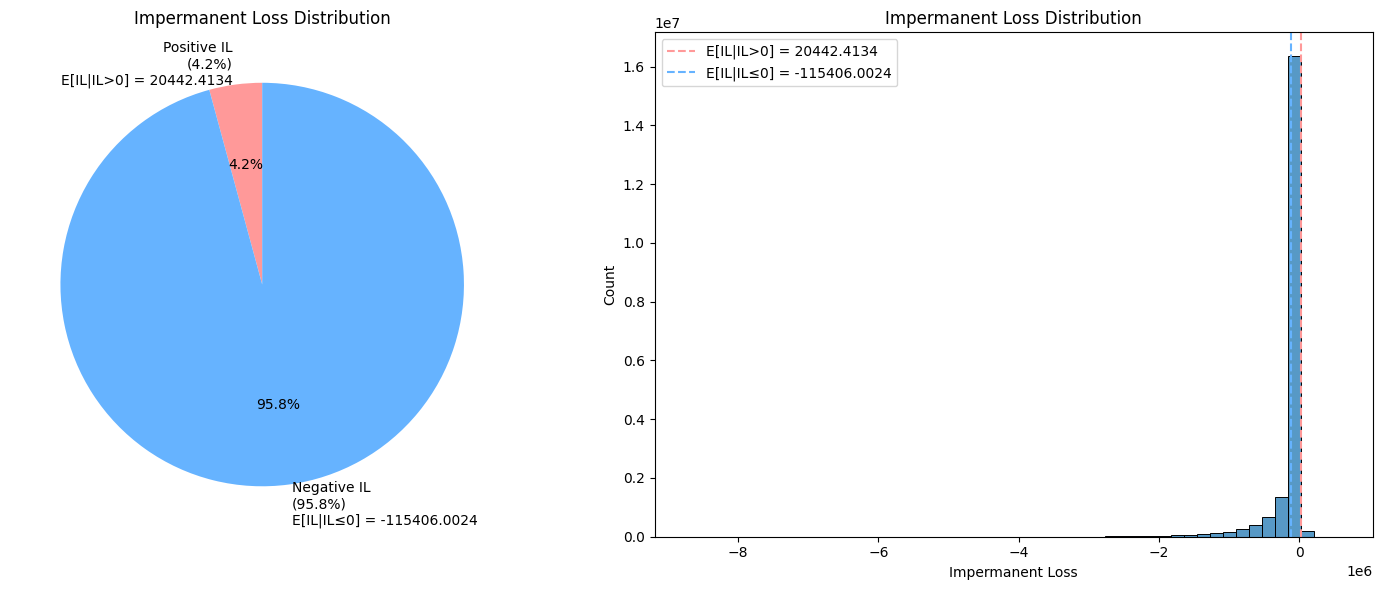

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_impermanent_loss(df):
    # Create figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calculate statistics
    positive_il = (df['impermanent_loss'] > 0).sum()
    total = len(df)
    positive_pct = (positive_il / total) * 100
    negative_pct = 100 - positive_pct
    
    ce_positive = df.filter(pl.col('impermanent_loss') > 0)['impermanent_loss'].mean()
    ce_negative = df.filter(pl.col('impermanent_loss') <= 0)['impermanent_loss'].mean()
    
    # Pie chart
    colors = ['#ff9999', '#66b3ff']
    axes[0].pie([positive_pct, negative_pct], 
                labels=[f'Positive IL\n({positive_pct:.1f}%)\nE[IL|IL>0] = {ce_positive:.4f}', 
                       f'Negative IL\n({negative_pct:.1f}%)\nE[IL|IL≤0] = {ce_negative:.4f}'],
                colors=colors,
                autopct='%1.1f%%',
                startangle=90)
    axes[0].set_title('Impermanent Loss Distribution')
    
    # Histogram
    sns.histplot(data=df, x='impermanent_loss', bins=50, ax=axes[1])
    axes[1].axvline(x=ce_positive, color='#ff9999', linestyle='--', 
                    label=f'E[IL|IL>0] = {ce_positive:.4f}')
    axes[1].axvline(x=ce_negative, color='#66b3ff', linestyle='--', 
                    label=f'E[IL|IL≤0] = {ce_negative:.4f}')
    axes[1].set_title('Impermanent Loss Distribution')
    axes[1].set_xlabel('Impermanent Loss')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    
    plt.tight_layout()
    return plt

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Create and show the plot
plot_impermanent_loss(df)
plt.show()

/tmp/ipykernel_869471/3207587621.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



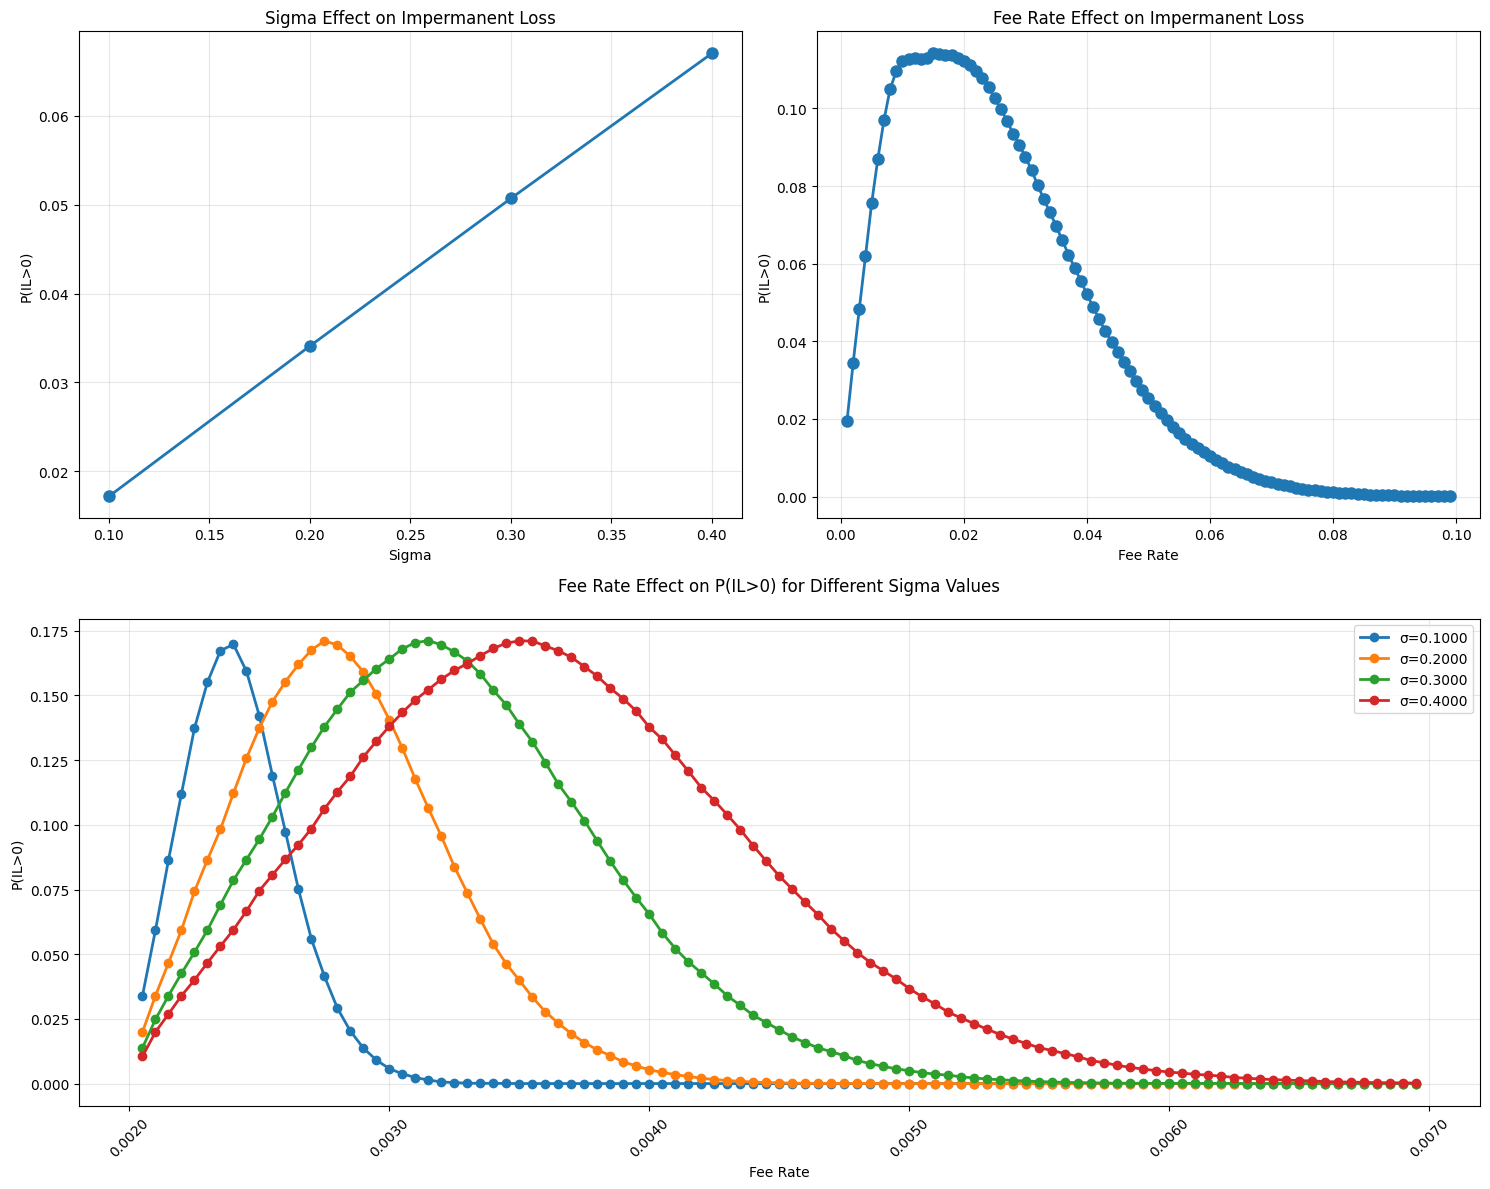

In [11]:
import polars as pl
import matplotlib.pyplot as plt

def plot_combined_effects(df):
    # Create figure with special layout
    fig = plt.figure(figsize=(15, 12))
    # Create GridSpec to handle the layout
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Add boolean column for positive IL
    df_stats = df.with_columns(pl.col('impermanent_loss').gt(0).alias('il_positive'))
    
    # Top row, first plot (Sigma Effect)
    ax1 = fig.add_subplot(gs[0, 0])
    sigma_effect = df_stats.group_by('sigma').agg(
        pl.mean('il_positive').alias('prob_il_positive')
    ).sort('sigma')
    
    ax1.plot(sigma_effect['sigma'], sigma_effect['prob_il_positive'], 
             marker='o', linewidth=2, markersize=8)
    ax1.set_title('Sigma Effect on Impermanent Loss', fontsize=12)
    ax1.set_xlabel('Sigma', fontsize=10)
    ax1.set_ylabel('P(IL>0)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Top row, second plot (Fee Rate Effect)
    ax2 = fig.add_subplot(gs[0, 1])
    fee_effect = df_stats.group_by('fee_rate').agg(
        pl.mean('il_positive').alias('prob_il_positive')
    ).sort('fee_rate')
    
    ax2.plot(fee_effect['fee_rate'], fee_effect['prob_il_positive'], 
             marker='o', linewidth=2, markersize=8)
    ax2.set_title('Fee Rate Effect on Impermanent Loss', fontsize=12)
    ax2.set_xlabel('Fee Rate', fontsize=10)
    ax2.set_ylabel('P(IL>0)', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Bottom row, spanning plot (IL Probability Lines)
    ax3 = fig.add_subplot(gs[1, :])
    
    # Plot lines for each sigma value
    for sigma in sorted(df_stats['sigma'].unique()):
        sigma_data = df_stats.filter(pl.col('sigma') == sigma)
        fee_effect = sigma_data.group_by('fee_rate').agg(
            pl.mean('il_positive').alias('prob_il_positive')
        ).sort('fee_rate')
        
        ax3.plot(fee_effect['fee_rate'], 
                fee_effect['prob_il_positive'], 
                label=f'σ={sigma:.4f}',
                marker='o',
                linewidth=2,
                markersize=6)
    
    ax3.set_title('Fee Rate Effect on P(IL>0) for Different Sigma Values', fontsize=12, pad=20)
    ax3.set_xlabel('Fee Rate', fontsize=10)
    ax3.set_ylabel('P(IL>0)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right')
    ax3.set_xticklabels([f'{x:.4f}' for x in fee_effect['fee_rate']], rotation=45)
    
    plt.tight_layout()
    return plt

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Create and show the combined plot
plot_combined_effects(df)
plt.show()

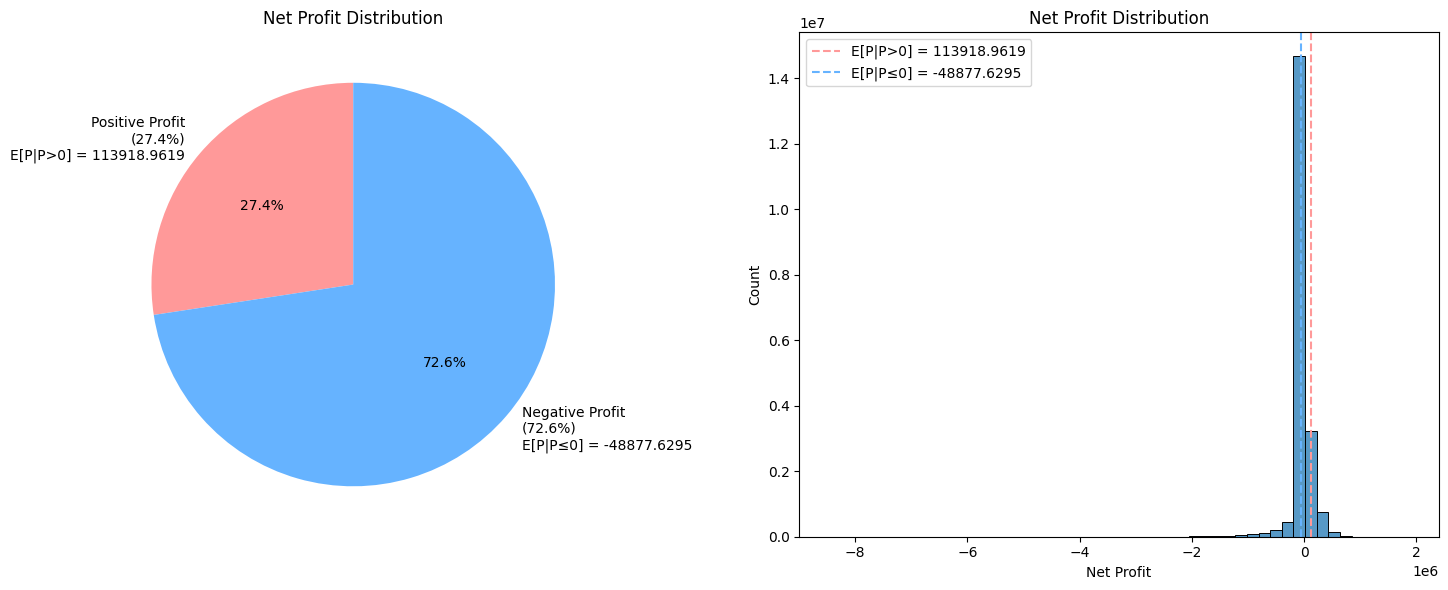

In [12]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_net_profit(df):
    # Create figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calculate statistics
    positive_profit = (df['net_profit'] > 0).sum()
    total = len(df)
    positive_pct = (positive_profit / total) * 100
    negative_pct = 100 - positive_pct
    
    ce_positive = df.filter(pl.col('net_profit') > 0)['net_profit'].mean()
    ce_negative = df.filter(pl.col('net_profit') <= 0)['net_profit'].mean()
    
    # Pie chart
    colors = ['#ff9999', '#66b3ff']
    axes[0].pie([positive_pct, negative_pct], 
                labels=[f'Positive Profit\n({positive_pct:.1f}%)\nE[P|P>0] = {ce_positive:.4f}', 
                       f'Negative Profit\n({negative_pct:.1f}%)\nE[P|P≤0] = {ce_negative:.4f}'],
                colors=colors,
                autopct='%1.1f%%',
                startangle=90)
    axes[0].set_title('Net Profit Distribution')
    
    # Histogram
    sns.histplot(data=df, x='net_profit', bins=50, ax=axes[1])
    axes[1].axvline(x=ce_positive, color='#ff9999', linestyle='--', 
                    label=f'E[P|P>0] = {ce_positive:.4f}')
    axes[1].axvline(x=ce_negative, color='#66b3ff', linestyle='--', 
                    label=f'E[P|P≤0] = {ce_negative:.4f}')
    axes[1].set_title('Net Profit Distribution')
    axes[1].set_xlabel('Net Profit')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    
    plt.tight_layout()
    return plt

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Create and show the plot
plot_net_profit(df)
plt.show()

/tmp/ipykernel_869471/3113565128.py:57: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



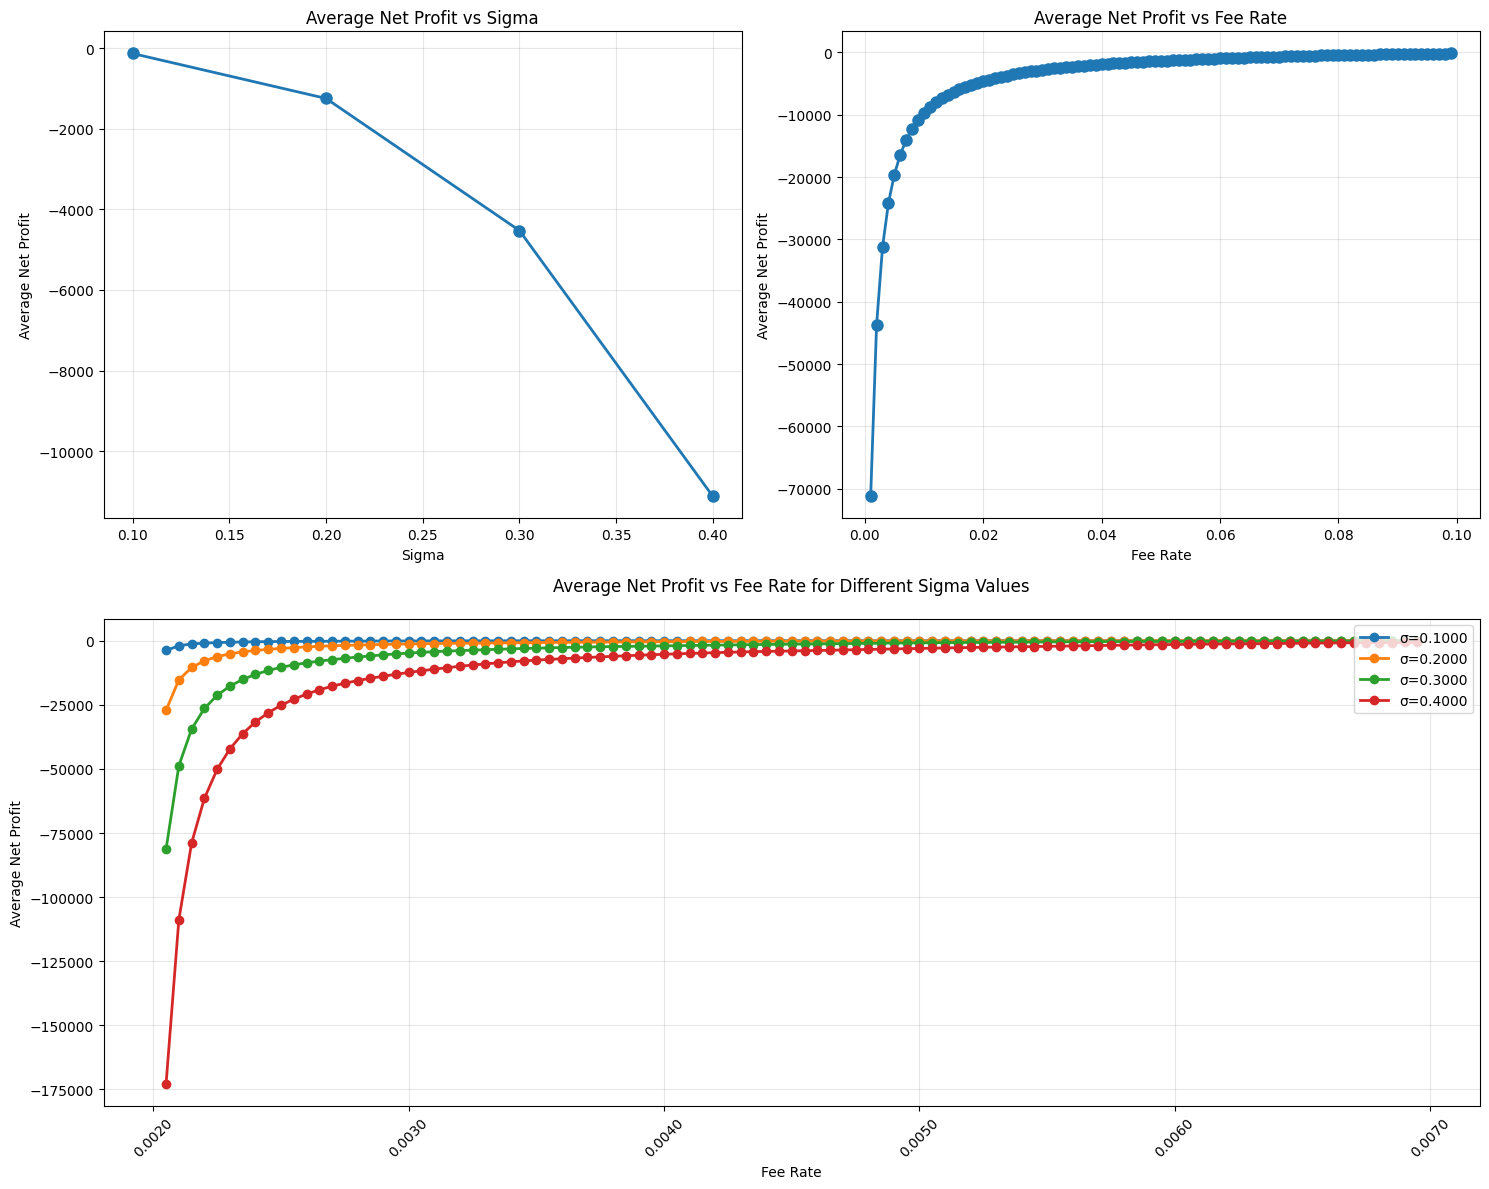

In [14]:
import polars as pl
import matplotlib.pyplot as plt

def plot_combined_profit_effects(df):
    # Create figure with special layout
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Top row, first plot (Sigma Effect)
    ax1 = fig.add_subplot(gs[0, 0])
    sigma_effect = df.group_by('sigma').agg(
        pl.mean('net_profit').alias('avg_net_profit')
    ).sort('sigma')
    
    ax1.plot(sigma_effect['sigma'], sigma_effect['avg_net_profit'], 
             marker='o', linewidth=2, markersize=8)
    ax1.set_title('Average Net Profit vs Sigma', fontsize=12)
    ax1.set_xlabel('Sigma', fontsize=10)
    ax1.set_ylabel('Average Net Profit', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Top row, second plot (Fee Rate Effect)
    ax2 = fig.add_subplot(gs[0, 1])
    fee_effect = df.group_by('fee_rate').agg(
        pl.mean('net_profit').alias('avg_net_profit')
    ).sort('fee_rate')
    
    ax2.plot(fee_effect['fee_rate'], fee_effect['avg_net_profit'], 
             marker='o', linewidth=2, markersize=8)
    ax2.set_title('Average Net Profit vs Fee Rate', fontsize=12)
    ax2.set_xlabel('Fee Rate', fontsize=10)
    ax2.set_ylabel('Average Net Profit', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Bottom row, spanning plot (Net Profit Lines)
    ax3 = fig.add_subplot(gs[1, :])
    
    # Plot lines for each sigma value
    for sigma in sorted(df['sigma'].unique()):
        sigma_data = df.filter(pl.col('sigma') == sigma)
        fee_effect = sigma_data.group_by('fee_rate').agg(
            pl.mean('net_profit').alias('avg_net_profit')
        ).sort('fee_rate')
        
        ax3.plot(fee_effect['fee_rate'], 
                fee_effect['avg_net_profit'], 
                label=f'σ={sigma:.4f}',
                marker='o',
                linewidth=2,
                markersize=6)
    
    ax3.set_title('Average Net Profit vs Fee Rate for Different Sigma Values', fontsize=12, pad=20)
    ax3.set_xlabel('Fee Rate', fontsize=10)
    ax3.set_ylabel('Average Net Profit', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right')
    ax3.set_xticklabels([f'{x:.4f}' for x in fee_effect['fee_rate']], rotation=45)
    
    plt.tight_layout()
    return plt

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Create and show the combined plot
plot_combined_profit_effects(df)
plt.show()

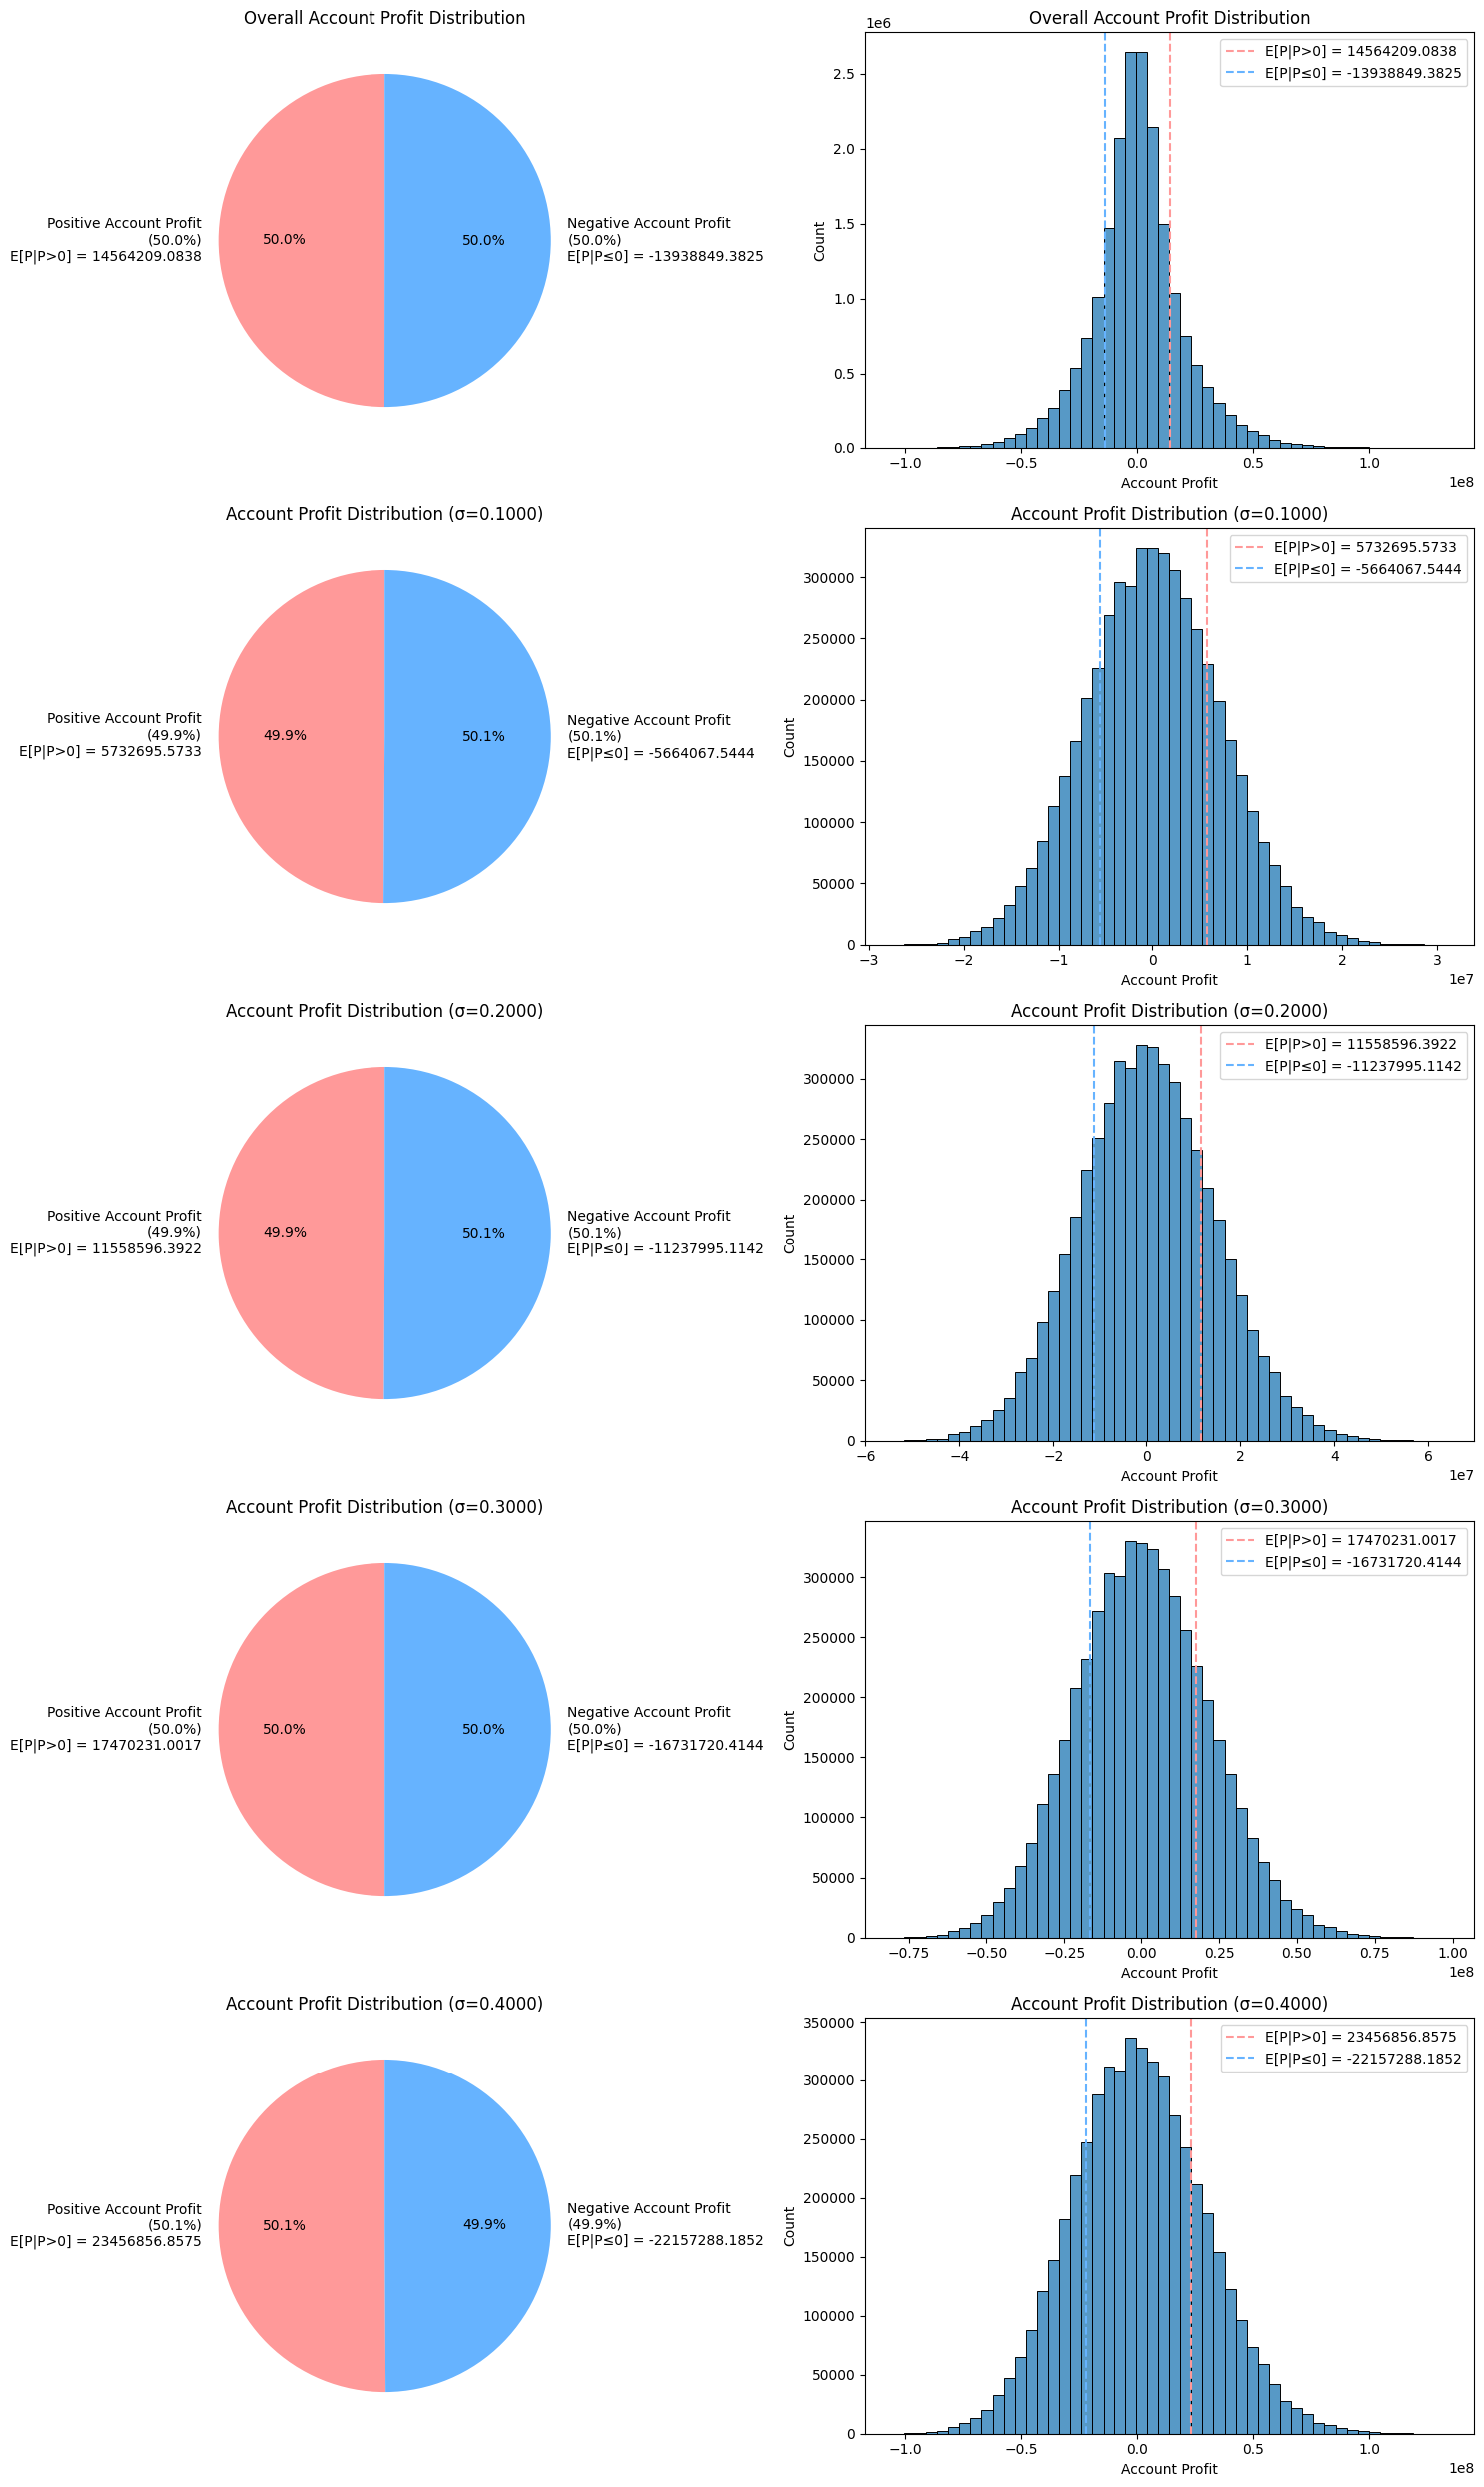

In [18]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_account_profit_by_sigma(df):
    # Get 4 representative sigma values
    sigma_values = sorted(df['sigma'].unique())[:4]  # Taking first 4 sigma values
    
    # Create figure with multiple rows
    fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 5 rows: 1 for overall, 4 for sigmas
    
    # First row: Overall distribution (same as before)
    positive_profit = (df['account_profit'] > 0).sum()
    total = len(df)
    positive_pct = (positive_profit / total) * 100
    negative_pct = 100 - positive_pct
    
    ce_positive = df.filter(pl.col('account_profit') > 0)['account_profit'].mean()
    ce_negative = df.filter(pl.col('account_profit') <= 0)['account_profit'].mean()
    
    # Overall pie chart
    colors = ['#ff9999', '#66b3ff']
    axes[0, 0].pie([positive_pct, negative_pct], 
                   labels=[f'Positive Account Profit\n({positive_pct:.1f}%)\nE[P|P>0] = {ce_positive:.4f}', 
                          f'Negative Account Profit\n({negative_pct:.1f}%)\nE[P|P≤0] = {ce_negative:.4f}'],
                   colors=colors,
                   autopct='%1.1f%%',
                   startangle=90)
    axes[0, 0].set_title('Overall Account Profit Distribution')
    
    # Overall histogram
    sns.histplot(data=df, x='account_profit', bins=50, ax=axes[0, 1])
    axes[0, 1].axvline(x=ce_positive, color='#ff9999', linestyle='--', 
                       label=f'E[P|P>0] = {ce_positive:.4f}')
    axes[0, 1].axvline(x=ce_negative, color='#66b3ff', linestyle='--', 
                       label=f'E[P|P≤0] = {ce_negative:.4f}')
    axes[0, 1].set_title('Overall Account Profit Distribution')
    axes[0, 1].set_xlabel('Account Profit')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    
    # Individual sigma rows
    for idx, sigma in enumerate(sigma_values, 1):
        sigma_df = df.filter(pl.col('sigma') == sigma)
        
        # Calculate statistics for this sigma
        positive_profit = (sigma_df['account_profit'] > 0).sum()
        total = len(sigma_df)
        positive_pct = (positive_profit / total) * 100
        negative_pct = 100 - positive_pct
        
        ce_positive = sigma_df.filter(pl.col('account_profit') > 0)['account_profit'].mean()
        ce_negative = sigma_df.filter(pl.col('account_profit') <= 0)['account_profit'].mean()
        
        # Pie chart for this sigma
        axes[idx, 0].pie([positive_pct, negative_pct], 
                        labels=[f'Positive Account Profit\n({positive_pct:.1f}%)\nE[P|P>0] = {ce_positive:.4f}', 
                               f'Negative Account Profit\n({negative_pct:.1f}%)\nE[P|P≤0] = {ce_negative:.4f}'],
                        colors=colors,
                        autopct='%1.1f%%',
                        startangle=90)
        axes[idx, 0].set_title(f'Account Profit Distribution (σ={sigma:.4f})')
        
        # Histogram for this sigma
        sns.histplot(data=sigma_df, x='account_profit', bins=50, ax=axes[idx, 1])
        axes[idx, 1].axvline(x=ce_positive, color='#ff9999', linestyle='--', 
                            label=f'E[P|P>0] = {ce_positive:.4f}')
        axes[idx, 1].axvline(x=ce_negative, color='#66b3ff', linestyle='--', 
                            label=f'E[P|P≤0] = {ce_negative:.4f}')
        axes[idx, 1].set_title(f'Account Profit Distribution (σ={sigma:.4f})')
        axes[idx, 1].set_xlabel('Account Profit')
        axes[idx, 1].set_ylabel('Count')
        axes[idx, 1].legend()
    
    plt.tight_layout()
    return plt

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Create and show the plot
plot_account_profit_by_sigma(df)
plt.show()

/tmp/ipykernel_869471/111422471.py:76: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



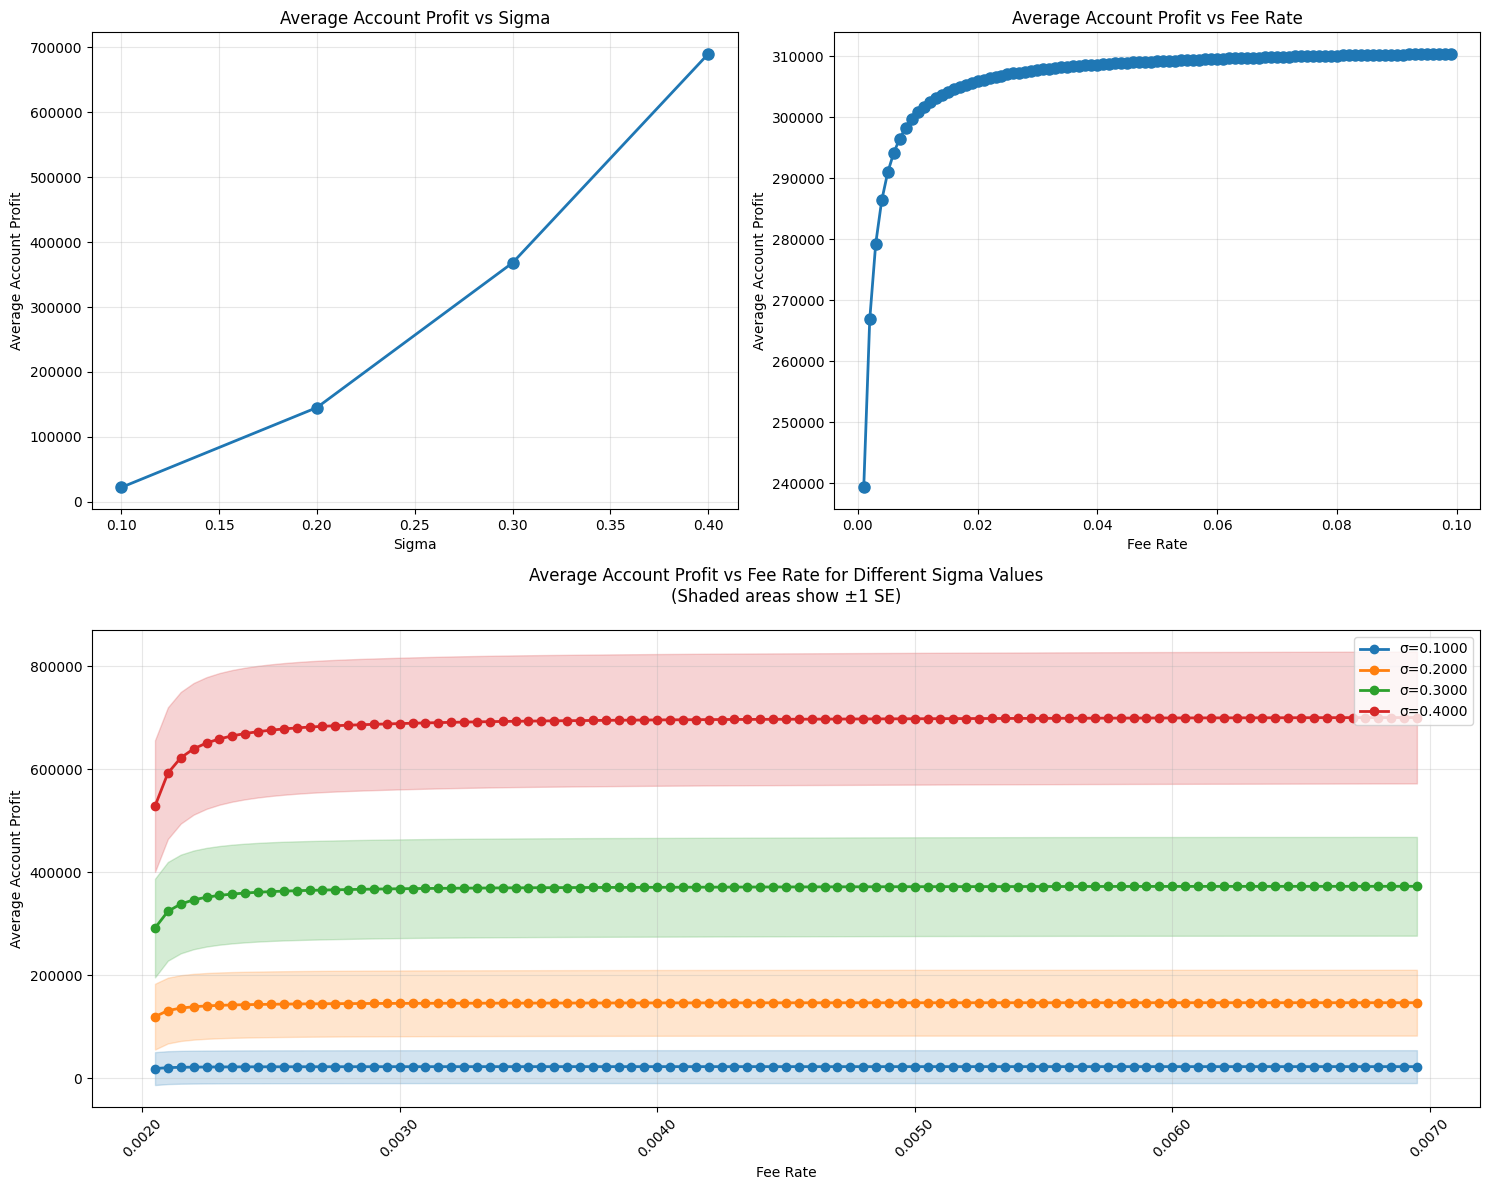

In [16]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_account_profit_effects(df):
    # Create figure with special layout
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Top row, first plot (Sigma Effect)
    ax1 = fig.add_subplot(gs[0, 0])
    sigma_effect = df.group_by('sigma').agg(
        pl.mean('account_profit').alias('avg_account_profit')
    ).sort('sigma')
    
    ax1.plot(sigma_effect['sigma'], sigma_effect['avg_account_profit'], 
             marker='o', linewidth=2, markersize=8)
    ax1.set_title('Average Account Profit vs Sigma', fontsize=12)
    ax1.set_xlabel('Sigma', fontsize=10)
    ax1.set_ylabel('Average Account Profit', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Top row, second plot (Fee Rate Effect)
    ax2 = fig.add_subplot(gs[0, 1])
    fee_effect = df.group_by('fee_rate').agg(
        pl.mean('account_profit').alias('avg_account_profit')
    ).sort('fee_rate')
    
    ax2.plot(fee_effect['fee_rate'], fee_effect['avg_account_profit'], 
             marker='o', linewidth=2, markersize=8)
    ax2.set_title('Average Account Profit vs Fee Rate', fontsize=12)
    ax2.set_xlabel('Fee Rate', fontsize=10)
    ax2.set_ylabel('Average Account Profit', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Bottom row, spanning plot (Account Profit Lines with confidence bands)
    ax3 = fig.add_subplot(gs[1, :])
    
    # Plot lines for each sigma value with confidence bands
    for sigma in sorted(df['sigma'].unique()):
        sigma_data = df.filter(pl.col('sigma') == sigma)
        
        # Calculate mean and standard error for each fee rate
        fee_stats = sigma_data.group_by('fee_rate').agg([
            pl.mean('account_profit').alias('avg_account_profit'),
            pl.std('account_profit').alias('std_account_profit'),
            pl.count('account_profit').alias('count')
        ]).sort('fee_rate')
        
        # Calculate standard error
        fee_stats = fee_stats.with_columns(
            (pl.col('std_account_profit') / pl.col('count').sqrt()).alias('se')
        )
        
        # Convert to numpy for plotting
        x = fee_stats['fee_rate'].to_numpy()
        y = fee_stats['avg_account_profit'].to_numpy()
        se = fee_stats['se'].to_numpy()
        
        # Plot mean line
        line = ax3.plot(x, y, 
                       label=f'σ={sigma:.4f}',
                       marker='o',
                       linewidth=2,
                       markersize=6)
        
        # Add confidence band (±1 standard error)
        ax3.fill_between(x, y-se, y+se, alpha=0.2, color=line[0].get_color())
    
    ax3.set_title('Average Account Profit vs Fee Rate for Different Sigma Values\n(Shaded areas show ±1 SE)', 
                  fontsize=12, pad=20)
    ax3.set_xlabel('Fee Rate', fontsize=10)
    ax3.set_ylabel('Average Account Profit', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right')
    ax3.set_xticklabels([f'{x:.4f}' for x in x], rotation=45)
    
    plt.tight_layout()
    return plt

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Create and show the combined plot
plot_combined_account_profit_effects(df)
plt.show()

In [19]:
import polars as pl

# Read the data
df = pl.read_parquet('/home/shiftpub/Dynamic_AMM/results/simulation_results_20241203_205259/final_results.parquet')

# Filter for specific fee_rate and sigma
specific_df = df.filter(
    (pl.col('fee_rate') == 0.002) & 
    (pl.col('sigma') == 0.2)
)

# Calculate percentage of positive profits
total_count = len(specific_df)
positive_count = (specific_df['account_profit'] > 0).sum()
positive_percentage = (positive_count / total_count) * 100

# Calculate mean profits
mean_profit = specific_df['account_profit'].mean()

# Calculate conditional means
mean_positive = specific_df.filter(pl.col('account_profit') > 0)['account_profit'].mean()
mean_negative = specific_df.filter(pl.col('account_profit') <= 0)['account_profit'].mean()

print(f"Analysis for fee_rate=0.002 and sigma=0.2:")
print(f"Total number of cases: {total_count}")
print(f"Number of positive profits: {positive_count}")
print(f"Percentage of positive profits: {positive_percentage:.2f}%")
print(f"\nMean profit: {mean_profit:.4f}")
print(f"Mean of positive profits: {mean_positive:.4f}")
print(f"Mean of negative profits: {mean_negative:.4f}")

Analysis for fee_rate=0.002 and sigma=0.2:
Total number of cases: 50000
Number of positive profits: 25050
Percentage of positive profits: 50.10%

Mean profit: 131078.1833
Mean of positive profits: 11505144.9569
Mean of negative profits: -11288576.0323
